In [2]:
import numpy as np
import datetime
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
df = pd.read_excel("/content/매출데이터(SuperStore).xls")
df.head()

,주문일,배송방식,고객명,고객분류,시군구(City),도(State),지역,제품대분류,제품소분류,이름,매출,수량,할인율,이익
0,2014-11-09,2등급,Claire Gute,개인고객,천안시,충청남도,충청,가구,책장,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2014-11-09,2등급,Claire Gute,개인고객,천안시,충청남도,충청,가구,의자,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,2014-06-13,2등급,Darrin Van Huff,기업고객,송파구,서울,수도권,사무용품,라벨,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,2013-10-11,표준등급,Sean O'Donnell,개인고객,영광군,전라남도,전라,가구,테이블,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,2013-10-11,표준등급,Sean O'Donnell,개인고객,영광군,전라남도,전라,사무용품,저장고,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [13]:
df['주문일2'] = df['주문일']
df.head(1)

,주문일,배송방식,고객명,고객분류,시군구(City),도(State),지역,제품대분류,제품소분류,이름,매출,수량,할인율,이익,주문일2
0,2014-11-09,2등급,Claire Gute,개인고객,천안시,충청남도,충청,가구,책장,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136,2014-11-09


In [14]:
#DataFrame의 groupby()의 multiple 연산을 위해 agg()을 이용
#Recency는 InvoiceDate 칼럼의 max()에서 데이터 가공
#Frequency는 InvoiceDate 칼럼의 count(), Monetary value 는 sale_amount 칼럼의 sum()
aggregations = {
    '주문일':'max',
    '주문일2':'count',
    '매출':'sum'
}
cust_df = df.groupby('고객명').agg(aggregations)

#groupby된 결과 칼럼 값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {'주문일':'Recency',
                                   '주문일2':'Frequency',
                                   '매출':'Monetary'
                                   }
                        )
cust_df = cust_df.reset_index()
cust_df.head(3)

,고객명,Recency,Frequency,Monetary
0,Aaron Bergman,2012-03-07,4,322.216
1,Aaron Hawkins,2015-12-19,10,1658.250
2,Aaron Smayling,2015-10-04,9,2962.618


In [15]:
df['주문일'].max()

Timestamp('2015-12-31 00:00:00')

In [16]:
cust_df['Recency'] = datetime.datetime(2015, 12, 31) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x : x.days+1)
cust_df

,고객명,Recency,Frequency,Monetary
0,Aaron Bergman,1395,4,322.216
1,Aaron Hawkins,13,10,1658.250
2,Aaron Smayling,89,9,2962.618
3,Adam Bellavance,55,17,7727.690
4,Adam Hart,35,11,1541.667
...,...,...,...,...
786,Xylona Preis,47,27,2323.718
787,Yana Sorensen,10,9,5798.224
788,Yoseph Carroll,481,4,1587.180
789,Zuschuss Carroll,55,24,7874.870


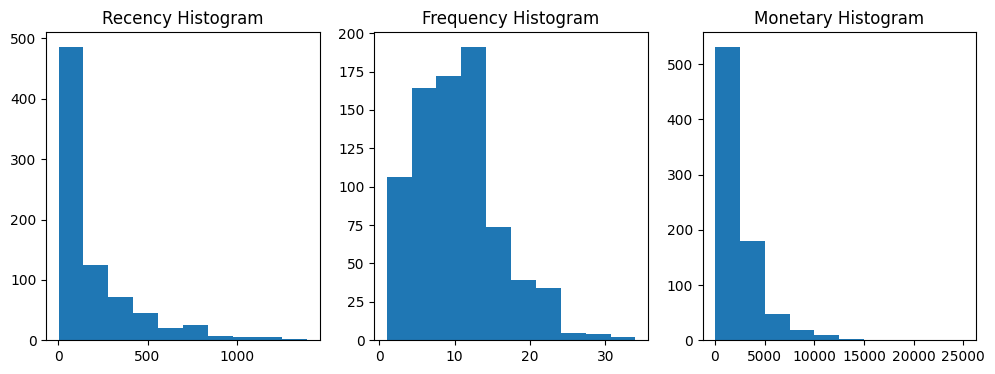

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

plt.show()

In [18]:
cust_df[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,791.000000,791.000000,791.000000
mean,190.548673,10.357775,2383.500784
std,233.396338,5.483895,2441.642097
min,1.000000,1.000000,4.833000
25%,38.000000,6.000000,870.064500
50%,98.000000,10.000000,1697.861000
75%,245.500000,13.000000,3042.466500
max,1395.000000,34.000000,25043.050000


# K-means

실루엣 스코어는 클러스터의 응집력(cohesion)과 분리력(separation)을 기반으로 각 데이터 포인트가 얼마나 잘 클러스터링되어 있는지 확인하는 지표임.
-1~1사이의 값을 가지고 높을수록 좋음

1에 가까운 실루엣 스코어: 데이터 포인트가 자신의 클러스터 내부에서 잘 맞아 떨어져 있음을 나타냄.
0에 가까운 실루엣 스코어: 클러스터링 결과가 겹치거나 중첩되어 있음을 나타냄.
-1에 가까운 실루엣 스코어: 데이터 포인트가 잘못된 클러스터에 할당되어 있음을 나타냄.


In [21]:
#StandScaler로 평균과 표준편차 재조정
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency', 'Frequency', 'Monetary']]#.values
X_features_scaled = StandardScaler().fit_transform(X_features) # 왜 df 그대로 안하고 ndarray로 바꿔서 스케일링하는거지?

#K-평균 수행
kmeans = KMeans(n_clusters=5, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어는 : 0.342


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k = 3 일 때 실루엣 스코어 : 0.390

k = 4 일 때 실루엣 스코어 : 0.362

k = 5 일 때 실루엣 스코어 : 0.342

In [22]:
#군집 개수별로 군집화 구성을 시각화 하는 함수
def visualize_kmeans_plot_multi(cluster_lists, X_features):

    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np

    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])

     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels

        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']

        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))
        axs[ind].legend(loc='upper right')

    plt.show()

In [23]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

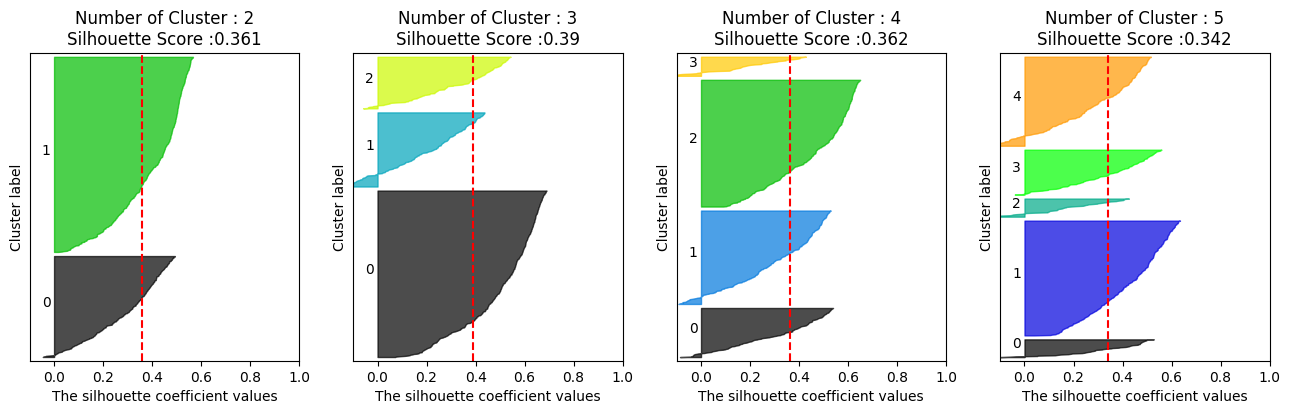

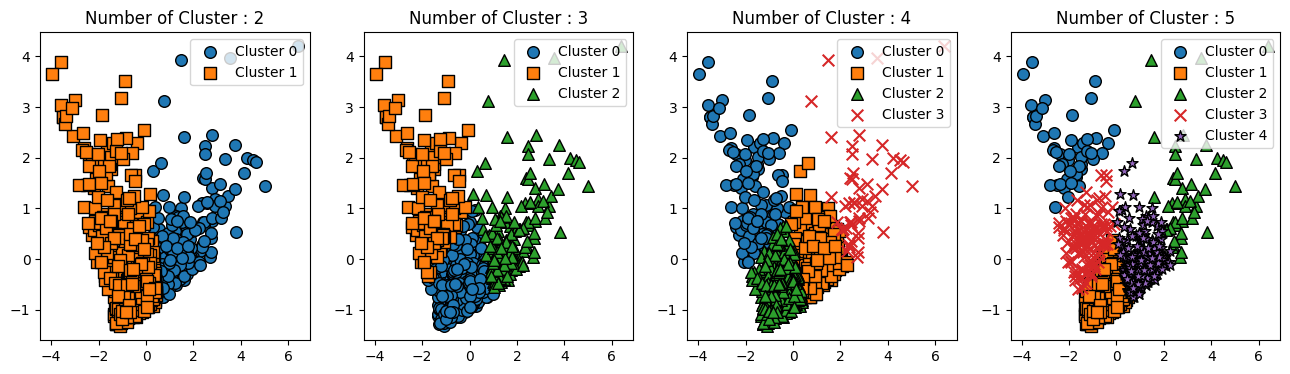

In [25]:
# 각 군집별 실루엣 계수 값 확인을 위해 군집 개수를 2~5개까지 변화시켜가며 군집화 구성 시각화
visualize_silhouette([2,3,4,5], X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

In [26]:
#데이터의 왜곡 정도를 낮추기 위해 로그 변환
#Recency, Frequency, Monetary 칼럼에 np.log1p()로 Log Transformation
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

#Log Transformation 데이터에 StandScaler 적용
X_features = cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']]#.values
X_features_scaled = StandardScaler().fit_transform(X_features)

#K-평균 수행
kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


실루엣 스코어는 : 0.271
